In [1]:
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage import morphology
from scipy import ndimage

from deeplate.MMdata import MMData

In [2]:
data_folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'
folder = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/usingsubset6/Analysis_201710126_lowerbound/'

In [3]:
posid = [re.findall('(?<=maskcorrect_)(\d+)(?=\.npy)',f) for f in os.listdir(folder)]
posid = [int(x[0]) for x in posid if len(x)>0]

In [4]:
MMobj = MMData(folder = data_folder)

In [5]:
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [6]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [7]:
mid_plane = int((MMobj.num_planes[bf_ch]-1)/2)

In [20]:
numpos = 3#len(posid)
mask = label(np.load(folder+'maskcorrect_'+str(posid[0])+'.npy'))
all_correlations = np.empty((mask.shape[0],mask.shape[1],numpos))
all_masks = np.empty((mask.shape[0],mask.shape[1],numpos))
all_weights = np.empty((mask.shape[0],mask.shape[1],numpos))

all_planes = np.empty((mask.shape[0],mask.shape[1],21, numpos))
#all_planes = np.empty((mask.shape[0],mask.shape[1],MMobj.num_planes[bf_ch],len(posid)))

for i in range(3):#range(len(posid)):
    print(i)
    all_masks[:,:,i] = np.load(folder+'maskcorrect_'+str(posid[i])+'.npy')
    all_weights[:,:,i] = np.load(folder+'weightcorrect_'+str(posid[i])+'.npy')
    all_correlations[:,:,i] = np.load(folder+'corr_'+str(posid[i])+'.npy')
    
    #mid = np.random.randint(mid_plane-5,mid_plane+6)
    for j in range(21):
        plane = mid_plane-10+j
        all_planes[:,:,j,i] = MMobj.get_image(frame=0,channel=bf_ch,plane=plane,position=posid[i], compress = 1)
    
    #all_planes[:,:,:,i] = MMobj.get_stack(0,bf_ch, posid[i],1)

0
1
2


In [21]:
multiply = 1
unitsize = 128
numsplits = int(all_masks.shape[0]/unitsize)
numimages = all_masks.shape[2]

#Definition of structures containing training and test datasets
#Dimensions and size of training and test datasets
channels = 10#1
image_rows = unitsize#128
image_cols = unitsize#128
num_test = 20
num_train = multiply*((numsplits**2*numimages)-num_test)


imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

In [22]:
listpos = []
for k in range(numimages):
    for i in range(numsplits):
        for j in range(numsplits):
            listpos.append([i,j,k])
            
shuffle = np.random.choice(len(listpos), len(listpos), replace=False)

all_weights[all_weights==1] = 200
all_weights[all_masks==1] = 20
all_weights[all_weights==0] = 1

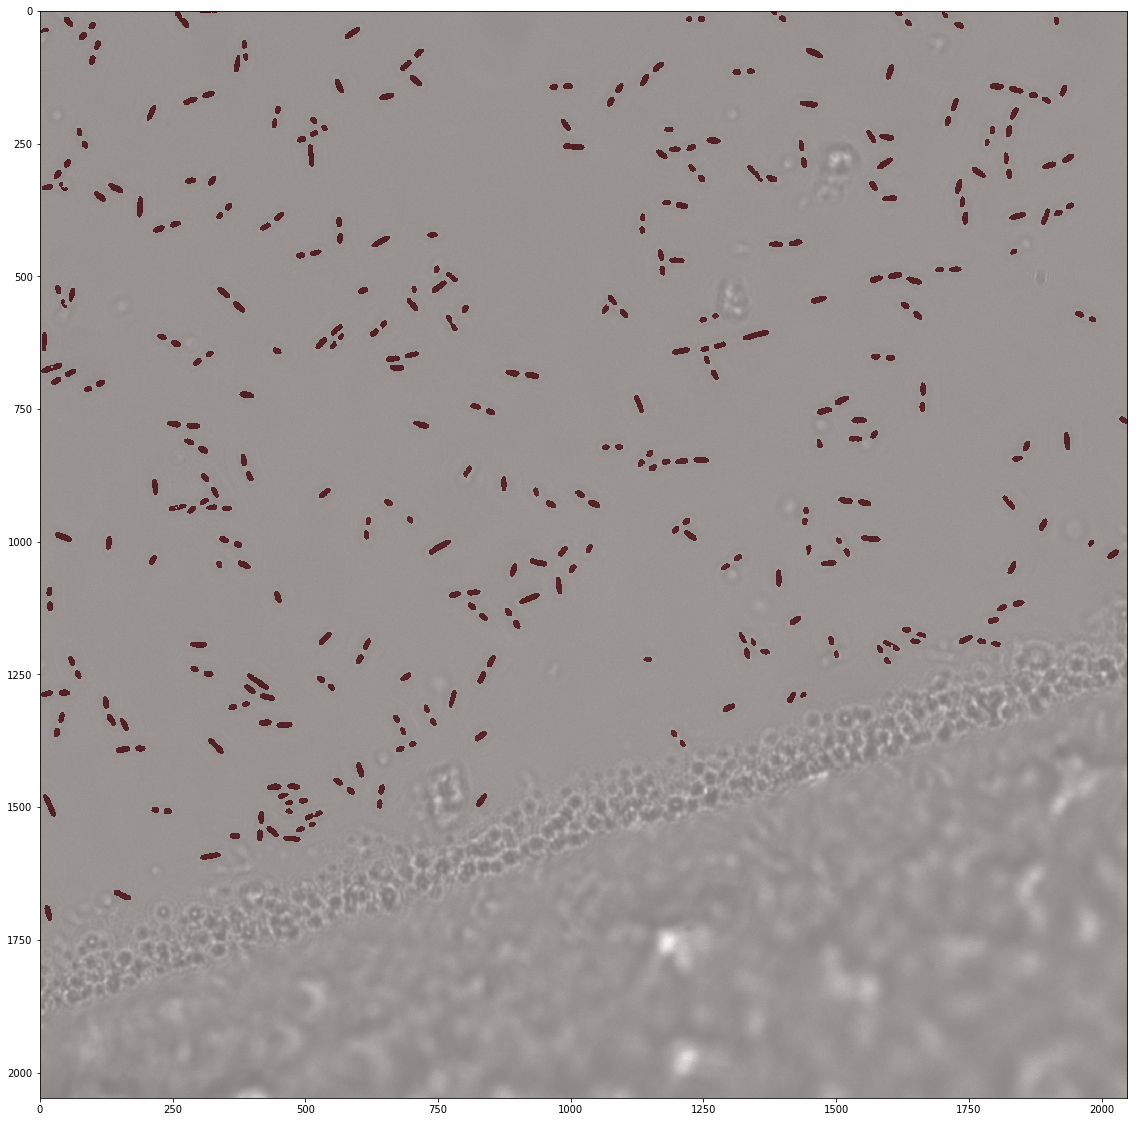

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(all_planes[:,:,0,2],cmap= 'gray')
plt.imshow(all_masks[:,:,2],alpha = 0.5,cmap='Reds')
plt.show()

In [23]:
counter_test = 0
for counter in range(len(listpos)):
    i=listpos[shuffle[counter]][0]
    j=listpos[shuffle[counter]][1]
    k=listpos[shuffle[counter]][2]
    
    
    
    #region around mid
    #mid = np.random.randint(mid_plane-3,mid_plane+3)
    init_rand = np.random.randint(0,21-10+1)
    img = all_planes[i*unitsize:(i+1)*unitsize,j*unitsize:(j+1)*unitsize,init_rand:init_rand+10,k]
    
    #distant planes around mid
    #mid = np.random.randint(mid_plane-3,mid_plane+3)
    #img = all_planes[i*128:(i+1)*128,j*128:(j+1)*128,[mid-10,mid,mid+10],k]
    #for m in range(3):
    #    img[:,:,m] = ndimage.gaussian_filter(img[:,:,m],3)
      
    #phase_corr around mid
    #mid = np.random.randint(mid_plane-6,mid_plane+6)
    #img = all_planes[i*128:(i+1)*128,j*128:(j+1)*128,:,k]
    #img = phase_corr_varying(img, mid, 800, 200, 6)
    #img = ndimage.gaussian_filter(img,3)
    
    #img = all_planes[i*image_rows:(i+1)*image_rows,j*image_cols:(j+1)*image_cols,:,k]
    #randint = np.random.rand() 
    #if np.random.rand()<0.5: randint = 10*randint
    #randint = 100*randint
    #img = img*randint
    img_mask = 255*all_masks[i*image_rows:(i+1)*image_rows,j*image_cols:(j+1)*image_cols,k]
    img_weight = all_weights[i*image_rows:(i+1)*image_rows,j*image_cols:(j+1)*image_cols,k]
      
    if multiply*counter<num_train:
        if channels==1:
            imgs[multiply*counter] = img[..., np.newaxis]
            #img = img.T
            #imgs[multiply*counter+1] = img[..., np.newaxis]
        else:
            imgs[multiply*counter] = img
            #img = np.transpose(img,(1,0,2))
            #imgs[2*counter+1] = img
        imgs_mask[multiply*counter] = img_mask
        #img_mask = img_mask.T
        #imgs_mask[2*counter+1] = img_mask
        imgs_weight[multiply*counter] = img_weight
        #img_weight = img_weight.T
        #imgs_weight[multiply*counter+1] = img_weight
    else:
        if channels==1:
            imgs_test[counter_test] = img[..., np.newaxis]
        else:
            imgs_test[counter_test] = img

        imgs_id[counter_test] = counter_test
        counter_test+=1

In [24]:
for i in range(imgs.shape[0]):
    randint = np.random.rand()+1
    if np.random.rand()<0.5: 
        randint = 1/randint
    imgs[i,:,:,:] = imgs[i,:,:,:]*randint

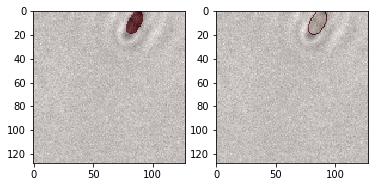

In [29]:
#check individul examples of training set
plt.subplot(1,2,1)
id = 310
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_mask[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.subplot(1,2,2)
plt.imshow(imgs[id,:,:,9],cmap = 'gray')
plt.imshow(np.reshape(imgs_weight[id,:],(image_rows,image_cols)),alpha = 0.5, cmap = 'Reds')
plt.show()

In [30]:
mean_val = np.mean(imgs)
std_val = np.std(imgs)

In [39]:
std_val

811.6689579294291

In [40]:
path_to_save = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_fullstack2/'

#save all the data structures
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
np.save(path_to_save+'imgs_train.npy', (imgs-mean_val)/std_val)
#np.save(path_to_save+'imgs_train.npy', imgs)
np.save(path_to_save+'imgs_mask_train.npy', imgs_mask.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_weight_train.npy', imgs_weight.reshape((num_train,image_cols*image_rows)))
np.save(path_to_save+'imgs_test.npy', (imgs_test-mean_val)/std_val)
np.save(path_to_save+'imgs_id_test.npy', imgs_id)

MemoryError: 

In [116]:
def phase_corr_varying(stack, midplane, thickness, z_step, numplanes):
   
    #corr_stack = stack
    num_max = np.max([midplane,stack.shape[2]-midplane])
    corr_stack = stack[:,:,midplane-numplanes:midplane+numplanes+1]
    nbplanes = corr_stack.shape[2]
    middle_plane = round((nbplanes-1)/2)
    
    heightpos = z_step*(np.arange(corr_stack.shape[2])-middle_plane)
    
    gaussderiv = -heightpos*np.exp(-heightpos**2/(2*thickness**2))
    gaussderiv = gaussderiv/np.linalg.norm(gaussderiv)
    #height_vals = height_vals[np.newaxis,np.newaxis,...]
    
    height_vals = np.empty(corr_stack.shape)
    height_vals[:] = gaussderiv
    
    image_norm = corr_stack/np.resize(np.sqrt(np.sum(corr_stack*corr_stack,axis =2)),
                                      (nbplanes, corr_stack.shape[0],corr_stack.shape[1])).transpose(1,2,0)
    
    #correlated_norm = ndimage.convolve(image_norm, height_vals, mode='constant', cval=0.0)
    #correlated_norm = scipy.signal.convolve(image_norm, height_vals, mode='valid')
    correlated_norm = image_norm*height_vals
    correlated_norm=np.sum(correlated_norm,axis =2)
    
    return correlated_norm